In [30]:
import numpy as np
import pandas as pd
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mping
import math
import datetime
import time

In [2]:
#Default dimensions 
img_width, img_height = 224, 224

#Create a bottleneck file
top_model_weight_path = 'bottleneck_fc_model.h5'

In [18]:
#loading datasets
train = "StockFish-1\\train"
test = "StockFish-1\\test"
valid = "StockFish-1\\valid"

In [19]:
#number of epochs to train top model
epochs = 15
#7

#batch size used by flow_from_directory and predict_generator
batch_size = 25

In [20]:
#loading vgg16 model
vgg16 = applications.VGG16(include_top = False, weights = 'imagenet')

In [21]:
#needed to create the bottleneck.npy files
datagen = ImageDataGenerator(rescale = 1. / 255)

In [22]:
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    train,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = intdatagen = ImageDataGenerator(rescale=1. / 255)
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    train,
    targ(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 719 images belonging to 5 classes.
29/29 [==============================] - 40s 1s/step
Time:  0:00:40.046453


In [23]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
    valid,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_valid_samples = len(generator.filenames)

predict_size_valid = int(math.ceil(nb_valid_samples / batch_size))

bottleneck_features_valid = vgg16.predict(
    generator, predict_size_valid
)

np.save('bottleneck_features_valid.npy', bottleneck_features_valid)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 207 images belonging to 5 classes.
9/9 [==============================] - 11s 1s/step
Time:  0:00:11.645049


In [24]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
    test,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_test_samples = len(generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))
bottleneck_features_test = vgg16.predict(generator, predict_size_test)
np.save('bottleneck_features_test.npy', bottleneck_features_test)
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Found 103 images belonging to 5 classes.
5/5 [==============================] - 6s 1s/step
Time:  0:00:06.294729


In [25]:
#training data
generator_top = datagen.flow_from_directory(
    train,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

#load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

#get the class label for the training data in the original order
train_labels = generator_top.classes

#convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes = num_classes)

Found 719 images belonging to 5 classes.


In [26]:
#validation data
generator_top = datagen.flow_from_directory(
    valid,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_valid_samples = len(generator_top.filenames)

valid_data = np.load('bottleneck_features_valid.npy')

valid_labels = generator_top.classes
valid_labels = to_categorical(valid_labels, num_classes = num_classes)

Found 207 images belonging to 5 classes.


In [27]:
#testing data
generator_top = datagen.flow_from_directory(
    test,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False
)

nb_test_samples = len(generator_top.filenames)

test_data = np.load('bottleneck_features_test.npy')

test_labels = generator_top.classes
test_labels = to_categorical(test_labels, num_classes = num_classes)

Found 103 images belonging to 5 classes.


In [31]:
#training the model
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape = train_data.shape[1:]))
model.add(Dense(100, activation = keras.layers.LeakyReLU(alpha = 0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation = keras.layers.LeakyReLU(alpha = 0.3)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate = 1e-4),
              metrics = ['acc'])

history = model.fit(train_data, train_labels,
                    epochs = 15,  #7
                    batch_size = batch_size,
                    validation_data = (valid_data, valid_labels))

model.save_weights(top_model_weight_path)

(eval_loss, eval_accuracy) = model.evaluate(
    valid_data, valid_labels, batch_size = batch_size, verbose = 1
)

print("[INFO] Accuracy: ", format(eval_accuracy * 100))
print("[INFO] Loss: ", format(eval_loss))
end = datetime.datetime.now()
elapsed = end - start
print('Time: ', elapsed)

Epoch 1/15
29/29 [==============================] - 2s 33ms/step - loss: 1.5292 - acc: 0.3505 - val_loss: 1.1643 - val_acc: 0.5121
Epoch 2/15
29/29 [==============================] - 1s 25ms/step - loss: 1.0951 - acc: 0.5452 - val_loss: 0.8170 - val_acc: 0.7053
Epoch 3/15
29/29 [==============================] - 1s 23ms/step - loss: 0.8247 - acc: 0.6843 - val_loss: 0.7515 - val_acc: 0.6522
Epoch 4/15
29/29 [==============================] - 1s 24ms/step - loss: 0.6397 - acc: 0.7566 - val_loss: 0.4770 - val_acc: 0.8454
Epoch 5/15
29/29 [==============================] - 1s 24ms/step - loss: 0.5038 - acc: 0.8053 - val_loss: 0.5812 - val_acc: 0.7295
Epoch 6/15
29/29 [==============================] - 1s 23ms/step - loss: 0.4376 - acc: 0.8456 - val_loss: 0.3888 - val_acc: 0.8502
Epoch 7/15
29/29 [==============================] - 1s 23ms/step - loss: 0.3223 - acc: 0.8957 - val_loss: 0.3057 - val_acc: 0.9275
Epoch 8/15
29/29 [==============================] - 1s 23ms/step - loss: 0.2886 - a

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2514205 (9.59 MB)
Trainable params: 2514

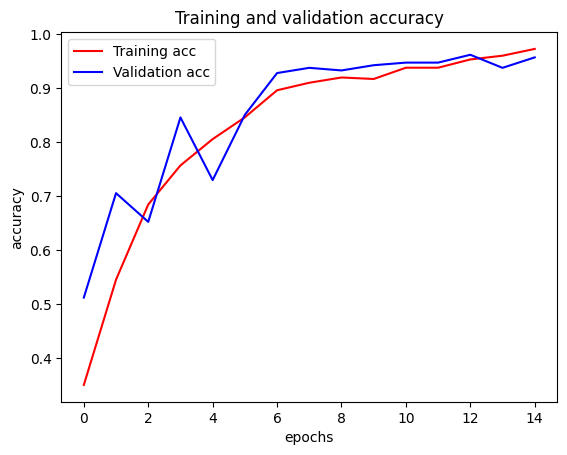

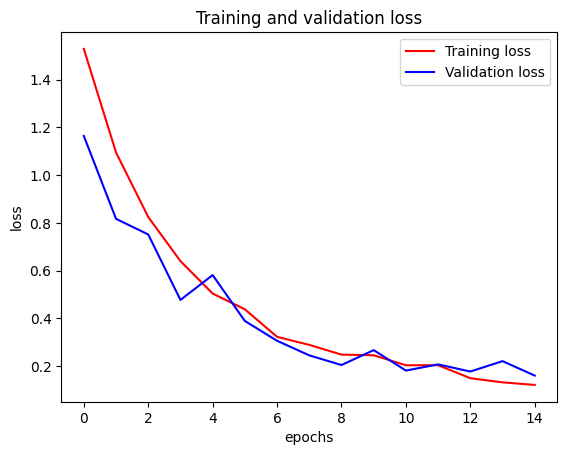

In [33]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [34]:
#model evaluation on testing data
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 5ms/step - loss: 0.1388 - acc: 0.9612


[0.13881519436836243, 0.9611650705337524]

In [35]:
#Classification metrics
print('test data', test_data)
preds = np.round(model.predict(test_data), 0)

#to fit them into classification metrics and confusion metrics, some additional modifications are required
print('Rounded test_labels', preds)

test data [[[[1.38385355e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    8.23268473e-01 0.00000000e+00]
   [0.00000000e+00 3.29277754e-01 0.00000000e+00 ... 0.00000000e+00
    6.12689495e-01 0.00000000e+00]
   [8.86367142e-01 2.58799613e-01 0.00000000e+00 ... 0.00000000e+00
    7.41988897e-01 0.00000000e+00]
   ...
   [6.29470825e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.63139486e+00 0.00000000e+00]
   [4.22879279e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.46933722e+00 0.00000000e+00]
   [2.76924014e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.93712616e+00 0.00000000e+00]]

  [[1.15594125e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.93276966e-01 0.00000000e+00]
   [5.74381530e-01 6.07451200e-02 0.00000000e+00 ... 0.00000000e+00
    3.14417422e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.99347866e-01 0.00000000e+00]
   ...
   [3.02219033e-01 0.00000000e+00 0.00000000e+0

In [36]:
fish = ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp']
classification_metrics = metrics.classification_report(test_labels, preds, target_names = fish, zero_division = 1)
print(classification_metrics)

              precision    recall  f1-score   support

       Catla       0.95      0.86      0.90        22
  CommonCarp       0.86      0.95      0.90        19
        Mori       1.00      1.00      1.00        16
        Rohu       1.00      0.95      0.97        19
  SilverCarp       1.00      1.00      1.00        27

   micro avg       0.96      0.95      0.96       103
   macro avg       0.96      0.95      0.96       103
weighted avg       0.96      0.95      0.96       103
 samples avg       0.96      0.95      0.99       103


In [37]:
#Confusion Matrix
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis = 1)
categorical_preds = pd.DataFrame(preds).idxmax(axis = 1)

In [38]:
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion matrix with normalization option'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else 'blue')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


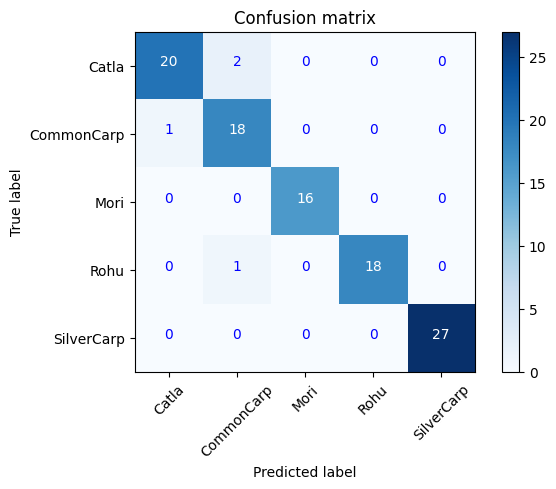

In [40]:
plot_confusion_matrix(confusion_matrix, ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp'])

Normalized confusion matrix


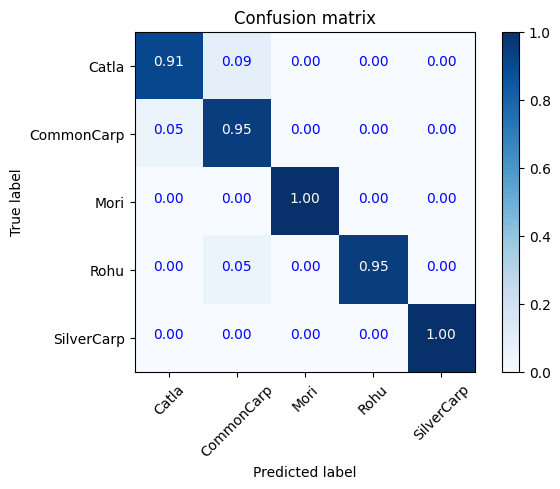

In [41]:
#Normalized confusion matrix
plot_confusion_matrix(confusion_matrix, ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp'],
                      normalize = True)

In [42]:
#testing images on model
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")
    image = load_img(file_path, target_size = (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image /= 255.
    return image

In [43]:
def test_single_image(path):
    fish = ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    for idx, fish, x in zip(range(0, 5), fish, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, fish, x*100 ))
    print("Final Decision: ")
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    #class_predicted = model.predict_classes(bt_prediction)
    class_predicted = model.predict(bt_prediction)
    classes = np.argmax(class_predicted, axis = 1)
    class_dictionary = generator_top.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()}
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[classes[0]]))
    return load_img(path)

In [49]:
path = r"static/silcafish.png"

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 27ms/step
ID: 0, Label: Catla 24.43382441997528%
ID: 1, Label: CommonCarp 0.47392542473971844%
ID: 2, Label: Mori 0.0029012615414103493%
ID: 3, Label: Rohu 0.0045097509428160265%
ID: 4, Label: SilverCarp 75.08482933044434%
Final Decision: 
.
..
...
1/1 [==============================] - 0s 22ms/step
ID: [2.4433824e-01 4.7392542e-03 2.9012615e-05 4.5097509e-05 7.5084829e-01], Label: SilverCarp


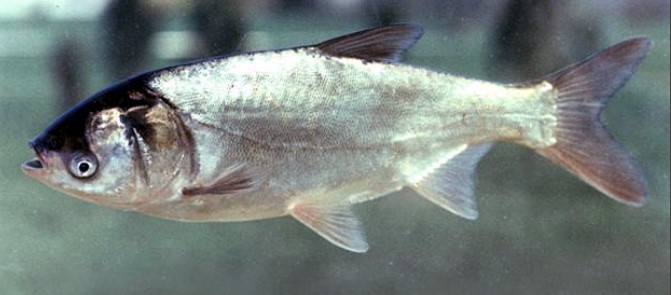

In [50]:
test_single_image(path)

In [51]:
# saving the model
model.save('fish.h5')

C:\Users\ritur\Desktop\AutoFis\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
# using model for predicting fish category
from tensorflow.keras.models import load_model
model = load_model('fish.h5')

In [53]:
def test_single_image(path):
    fish = ['Catla', 'CommonCarp', 'Mori', 'Rohu', 'SilverCarp']
    images = read_image(path)
    # time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    for idx, fish, x in zip(range(0, 5), fish, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, fish, x*100 ))
    print("Final Decision: ")
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    #class_predicted = model.predict_classes(bt_prediction)
    class_predicted = model.predict(bt_prediction)
    classes = np.argmax(class_predicted, axis = 1)
    class_dictionary = generator_top.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()}
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[classes[0]]))
    return load_img(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 61ms/step
ID: 0, Label: Catla 24.43382441997528%
ID: 1, Label: CommonCarp 0.47392542473971844%
ID: 2, Label: Mori 0.0029012615414103493%
ID: 3, Label: Rohu 0.0045097509428160265%
ID: 4, Label: SilverCarp 75.08482933044434%
Final Decision: 
.
..
...
1/1 [==============================] - 0s 22ms/step
ID: [2.4433824e-01 4.7392542e-03 2.9012615e-05 4.5097509e-05 7.5084829e-01], Label: SilverCarp


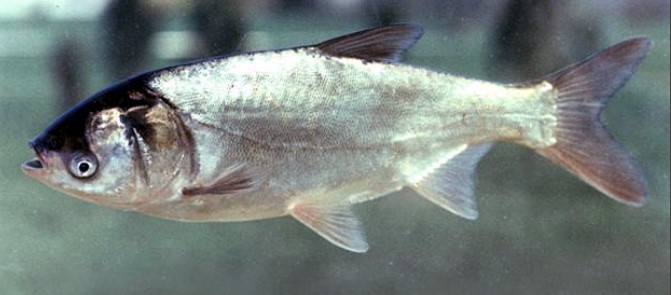

In [54]:
test_single_image(path)